<a href="https://colab.research.google.com/github/EdwardAA/BREI/blob/main/VAE22_7_Conv_MNIST2_Simple_Dependence_Kalman_(5)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** *italicized text*Data Generator**

In [2]:
##################################################################################################################
#  IDEA: World model for data
##################################################################################################################
#  fit one model for all data, while track the temporal data!
##################################################################################################################
# 1. use the same VAE to model entire dataset
# 2. use the transformed data by the VAE as samples from multivariate gaussian distributed samples
# 3. use the order of data to check for the dynamcis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
image_size=40 # number of pixels per rows and columns
number_of_samples=500   # number of samples per each time point
Total_samples=number_of_samples
ttime=10 # total time
# Change_Point=5 # point where ditsribution of data changes

In [4]:
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

In [5]:
import cv2 as cv
import os
import random
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
#generates jpg image of input digit at input angle, digit is rotated ccw
def num_generator(digit, angle):
    #generate blank image
    height = 60
    width = 60
    img = np.zeros((height,width,3), np.uint8)
    img.fill(255)
    rows,cols,rbg = img.shape

    #generate image of digit on the blank image
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 1
    text_size = cv.getTextSize(digit, font, font_scale, font_thickness)
    #print(text_size)
    x,y = text_size[0]
    cv.putText(img, digit, (int(rows/2 - x/2), int(cols/2 + y/2)), font, font_scale, (0,0,0), font_thickness, cv.LINE_AA)
        
    M = cv.getRotationMatrix2D(((rows-1)/2.0,(cols-1)/2.0), angle, 1)
    rot_img = cv.warpAffine(img,M,(rows,cols))
    #crop image to 28x28
    new_img_size = 40
    crop_img = rot_img[int((width-new_img_size)/2):int(new_img_size+((width-new_img_size)/2)),int((height-new_img_size)/2):int(new_img_size+((height-new_img_size)/2))]
    #post processing
    err=np.random.rand(new_img_size,new_img_size)*10
    crop_img=(rgb2gray(crop_img)+err)/(255+10)
    return crop_img

In [6]:
T=ttime # total time point
N=number_of_samples # number of samples per each time point
# ChangePoint=Change_Point # point where ditsribution of data changes
XT=np.zeros((T,N,image_size,image_size))
for t in range(T):# time 
    XT[t]=num_generator('8', t*20)
print(XT.shape)

(10, 500, 40, 40)


**AutoEncoder**

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
latent_dim = 2

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
from tensorflow.keras import initializers
latent_dim = 2
encoder_inputs = keras.Input(shape=(image_size,image_size, 1), name="encoder_inputs")
CONV1 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="CONV1", kernel_initializer='glorot_uniform', bias_initializer='zeros')
CONV2 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same",name="CONV2", kernel_initializer='glorot_uniform', bias_initializer='zeros')
Flatten = layers.Flatten(name="Flatten")
DENSE = layers.Dense(16, activation="relu",name="DENSE", kernel_initializer='glorot_uniform', bias_initializer='zeros')
z_mean_layer = layers.Dense(latent_dim, name="z_mean", kernel_initializer='random_normal', bias_initializer='zeros')
z_log_var_layer = layers.Dense(latent_dim, name="z_log_var", kernel_initializer='random_normal', bias_initializer='zeros')
SAMPLING=Sampling(name="SAMPLING")
######################################################
x = CONV1(encoder_inputs)
x = CONV2(x)
x=Flatten(x)
x=DENSE(x)
z_mean = z_mean_layer(x)
z_log_var = z_log_var_layer(x)
z = SAMPLING([z_mean, z_log_var])
######################################################
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 CONV1 (Conv2D)                 (None, 20, 20, 64)   640         ['encoder_inputs[0][0]']         
                                                                                                  
 CONV2 (Conv2D)                 (None, 10, 10, 32)   18464       ['CONV1[0][0]']                  
                                                                                                  
 Flatten (Flatten)              (None, 3200)         0           ['CONV2[0][0]']                  
                                                                                            

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,), name="latent_inputs")
######################################################
DENSE2 = layers.Dense(10 * 10 * 64, activation="relu", name="DENSE2", kernel_initializer='glorot_uniform', bias_initializer='zeros')
Conv2DTranspose1 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", name="Conv2DTranspose1",kernel_initializer='glorot_uniform', bias_initializer='zeros')
Conv2DTranspose2 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="Conv2DTranspose2",kernel_initializer='glorot_uniform', bias_initializer='zeros')
Conv2DTranspose3 = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name="Conv2DTranspose3", kernel_initializer='glorot_uniform', bias_initializer='zeros')
######################################################
x = DENSE2(latent_inputs)
x = layers.Reshape((10, 10, 64),name="RESHAPE")(x)
x = Conv2DTranspose1(x)
x = Conv2DTranspose2(x)
decoder_outputs = Conv2DTranspose3(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_inputs (InputLayer)  [(None, 2)]               0         
                                                                 
 DENSE2 (Dense)              (None, 6400)              19200     
                                                                 
 RESHAPE (Reshape)           (None, 10, 10, 64)        0         
                                                                 
 Conv2DTranspose1 (Conv2DTra  (None, 20, 20, 64)       36928     
 nspose)                                                         
                                                                 
 Conv2DTranspose2 (Conv2DTra  (None, 40, 40, 32)       18464     
 nspose)                                                         
                                                                 
 Conv2DTranspose3 (Conv2DTra  (None, 40, 40, 1)        289 

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [12]:
ENCODER=[]
DECODER=[]
MU_W=[]
MU_B=[]
S_W=[]
S_B=[]
t=0
######################################################
#data sample 
######################################################
# x_train=XT[t]
x_train=XT.reshape(-1,image_size,image_size)
# x_train=np.expand_dims(x_train, -1).astype("float32") / 255
x_train=np.expand_dims(x_train, -1).astype("float32")
######################################################
#fitting model
######################################################
vae = VAE(encoder,decoder)
# Wsave = vae.get_weights()
# print(' parameter before training: \n',encoder.get_layer("z_mean").get_weights()[0].reshape(1,-1))
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=32)
# print(' parameter after training: \n',encoder.get_layer("z_mean").get_weights()[0].reshape(1,-1))
######################################################
#store wieghts
######################################################
MU_W.append(encoder.get_layer("z_mean").get_weights()[0].reshape(1,-1))
MU_B.append(encoder.get_layer("z_mean").get_weights()[1].reshape(1,-1))
S_W.append(encoder.get_layer("z_log_var").get_weights()[0].reshape(1,-1))
S_B.append(encoder.get_layer("z_log_var").get_weights()[1].reshape(1,-1))

Epoch 1/10
157/157 [==============================] - 26s 149ms/step - loss: 615.6048 - reconstruction_loss: 439.9491 - kl_loss: 0.5167
Epoch 2/10
157/157 [==============================] - 19s 119ms/step - loss: 344.6571 - reconstruction_loss: 342.7565 - kl_loss: 0.0460
Epoch 3/10
157/157 [==============================] - 19s 119ms/step - loss: 339.0763 - reconstruction_loss: 338.3763 - kl_loss: 0.0619
Epoch 4/10
157/157 [==============================] - 19s 120ms/step - loss: 334.4958 - reconstruction_loss: 326.7061 - kl_loss: 1.6095
Epoch 5/10
157/157 [==============================] - 19s 120ms/step - loss: 309.9297 - reconstruction_loss: 301.1303 - kl_loss: 4.1483
Epoch 6/10
157/157 [==============================] - 19s 122ms/step - loss: 291.1917 - reconstruction_loss: 280.7596 - kl_loss: 5.5530
Epoch 7/10
157/157 [==============================] - 20s 127ms/step - loss: 274.1311 - reconstruction_loss: 264.6988 - kl_loss: 6.5263
Epoch 8/10
157/157 [============================

[array([[ 0.9937524, -2.062752 ]], dtype=float32),
 array([[-5.5765567, -5.027329 ]], dtype=float32),
 array([[ 0.9690818, -2.0996094]], dtype=float32)]

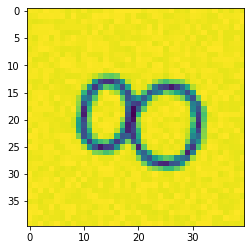

In [13]:
plt.imshow(XT[4,1])
vae.encoder.predict(XT[4,1].reshape(1,40,40))

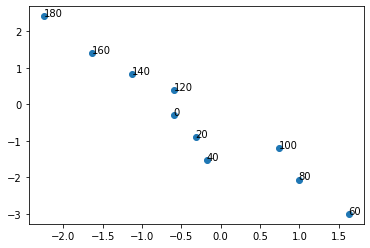

In [14]:
#plot the laten space of the rotating digits
Z_mean =[]
Z_MEAN=np.zeros((ttime,2))
Z_MEAN2=np.zeros((ttime,3))
label=[]
for i in range(ttime):
  z_mean, _, _ = vae.encoder.predict(XT[i])
  Z_MEAN[i]=np.mean(z_mean,0) # average of the exncoded samples per each iteration
  label.append(i*20)

plt.scatter(Z_MEAN[:,0],Z_MEAN[:,1])
for i, txt in enumerate(label):
       plt.annotate(txt, (Z_MEAN[i,0], Z_MEAN[i,1]))

# fig, ax = plt.subplots()
# ax.scatter(Z_MEAN[:,0],Z_MEAN[:,1])
# for i, txt in enumerate(label):
#   ax.annotate(txt, (Z_MEAN[i,0], Z_MEAN[i,1]))


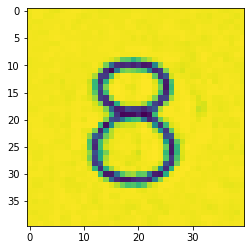

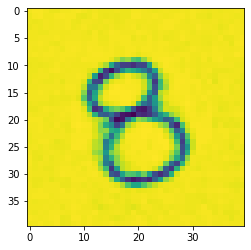

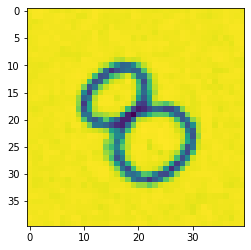

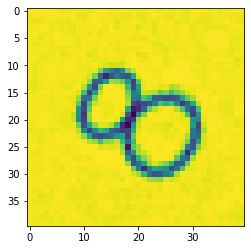

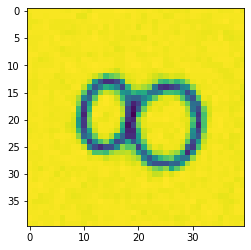

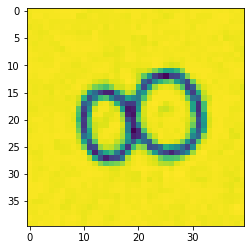

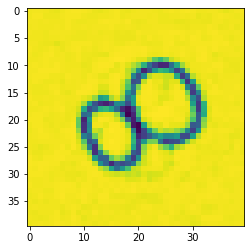

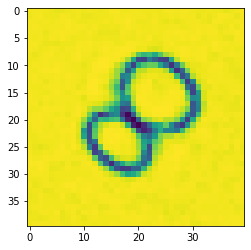

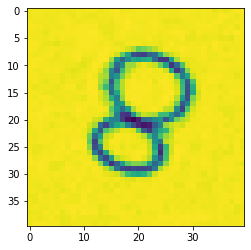

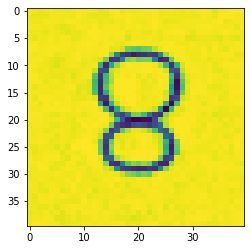

In [15]:
# ######################################################
#plot of the recostructed  shapes from latent space
# ######################################################
for i in range(ttime):
  x_decoded = vae.decoder.predict(Z_MEAN[i].reshape(1,2))
  digit = x_decoded.reshape(image_size, image_size)
  # plt.imshow(digit)
  # axs[i].set_title('recustructed image for time:'+ str(t)+'based on bias:'+str(Bias[i]))
  # #fig.suptitle('f model'+ str(i))
  plt.show()
  plt.imshow(digit)

# ***Control Chart***

In [16]:
######################################################
# Instal pyspc  
#  NOTE: the package has a wierd bug sometimes messing with numpy!! (somtimes need numpy reinstallation)
#  NOTE II: it also doesnt work with highliy correlated variables (due to the singulatrty issue ); REMEDY: hard coding the control chart 
######################################################
# !pip install pyspc
# from pyspc import *
######################################################
# T2 control chart for teh paremeter 
######################################################
# d4 = spc(Z_MEAN) + mewma() + rules()
# print(d4)

## **Kalman Filter**

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [18]:
num_steps = ttime-1
ground_truth_states=Z_MEAN # average of the exncoded samples per each iteration

In [19]:
######################################################
#predict
######################################################
def predict(A, B, Q, u_t, mu_t, Sigma_t):
    predicted_mu = A @ mu_t + B @ u_t
    predicted_Sigma = A @ Sigma_t @ A.T + Q
    return predicted_mu, predicted_Sigma
######################################################
#Update
######################################################
def update(H, R, z, predicted_mu, predicted_Sigma):
    residual_mean = z - H @ predicted_mu
    residual_covariance = H @ predicted_Sigma @ H.T + R
    kalman_gain = predicted_Sigma @ H.T @ np.linalg.inv(residual_covariance)
    updated_mu = predicted_mu + kalman_gain @ residual_mean
    updated_Sigma = predicted_Sigma - kalman_gain @ H @ predicted_Sigma
    return updated_mu, updated_Sigma

In [20]:
# test
# x_decoded=vae.decoder.predict(np.array([[-10,0]]))
# digit = x_decoded[0].reshape(image_size, image_size)
# plt.show()
# plt.imshow(digit)

In [44]:
np.mean(XT[0],0)

array([[0.98997907, 0.98028449, 0.98241741, ..., 0.98732133, 0.99985153,
        0.97027959],
       [0.9745062 , 0.98927113, 0.99026389, ..., 0.97374057, 0.96609585,
        0.97631492],
       [0.9641972 , 0.98045549, 0.96586538, ..., 0.96634192, 0.96837279,
        0.96306326],
       ...,
       [0.96536577, 0.96753075, 0.96259624, ..., 0.98247015, 0.97058206,
        0.98846504],
       [0.98540544, 0.99157352, 0.97463996, ..., 0.96544565, 0.98194985,
        0.99560557],
       [0.99163913, 0.97592239, 0.9803699 , ..., 0.97189213, 0.9682827 ,
        0.99821972]])

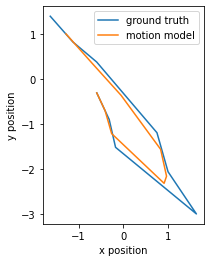

In [21]:
######################################################
# initialize the problem with the given information
# use the inital step of VAE 
######################################################
init=np.mean(XT[0],0).reshape(1,40,40)
z_mean, std, _ =vae.encoder.predict(init)
mu_0=z_mean.reshape(2) # average of the exncoded samples per each iteration
Sigma_0=std*np.eye(2)
######################################################
# Paramters
######################################################
u_t = np.array([0, 0]) # we assume constant control input

A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.1, 0],
              [0, 0.1]])
H = np.array([[1, 0],
              [0, 1]])
R = np.array([[0.1, 0],
              [0, 0.1]])

# Initialize empty lists to store the filtered states and measurements for plotting
measurement_states = []
filtered_states = []

# Run KF for each time step
mu_current = mu_0.copy()
Sigma_current = Sigma_0.copy()
for i in range(num_steps):
    
    # Predict step
    predicted_mu, predicted_Sigma = predict(A, B, Q, u_t, mu_current, Sigma_current)
    
    # Get measurement (in real life, we get this from our sensor)    
    # measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    # new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    
    # z_mean, _, _ = vae.encoder.predict(XT[i])
    # new_measurement=z_mean.reshape(2)
    new_measurement=Z_MEAN[i]
    
    # The rest of update step
    mu_current, Sigma_current = update(H, R, new_measurement, predicted_mu, predicted_Sigma)
    
    # Store measurements and mu_current so we can plot it later
    measurement_states.append(new_measurement)
    filtered_states.append(mu_current)

# For plotting purposes, convert the lists to array
measurement_states = np.array(measurement_states)
filtered_states = np.array(filtered_states) 

######################################################
# plot the results
######################################################
# plt.plot(ground_truth_states[:,0], ground_truth_states[:,1]) # from previous section
# plt.plot(motion_states[:,0], motion_states[:,1]) # from previous section
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
# plt.xlim(-30,30)
# plt.ylim(-30,30)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements', 'KF'])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

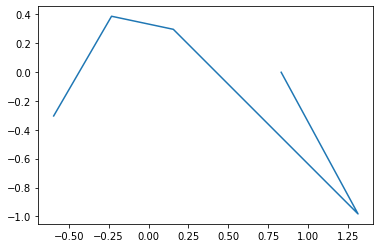

In [22]:
######################################################
# Simulate Dynamics
######################################################
motion_states = [filtered_states[0,:]] # a list to store state at each step following noisy motion model
# motion_states=[np.zeros([1,2])]
# motion_states=[0,0]
for _ in range(4):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=10*Q) # ~N(0,Q)
    new_state = A @ motion_states[-1] + B @ u_t + motion_noise # note: a @ b = np.dot(a,b)
    motion_states.append(new_state)

motion_states = np.array(motion_states)
plt.plot(motion_states[:,0], motion_states[:,1])


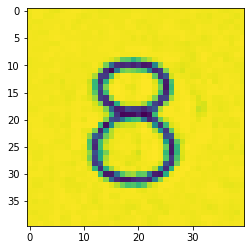

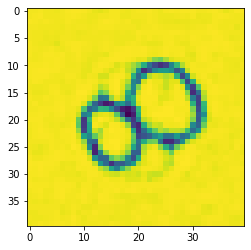

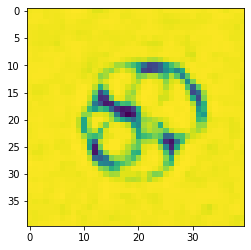

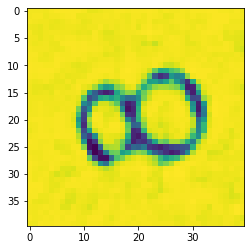

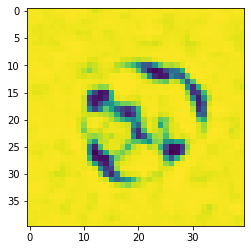

In [23]:
######################################################
#plot of the prediction the 
######################################################
Z_SAMPLE=motion_states
row=Z_SAMPLE.shape[0]
# z_sample=np.zeros((1,2))
for k in range(row):
  z_sample = Z_SAMPLE[k].reshape(1,2)
  x_decoded = vae.decoder.predict(z_sample)
  #print(x_decoded[0].shape)
  digit = x_decoded[0].reshape(image_size, image_size)
  # plt.imshow(digit)
  # axs[i].set_title('recustructed image for time:'+ str(t)+'based on bias:'+str(Bias[i]))
  # #fig.suptitle('f model'+ str(i))
  plt.show()
  plt.imshow(digit)



## **Kalman Filter with PSO for the Paramters**

In [24]:
!pip install pyswarms
import pyswarms as ps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 104 kB 5.3 MB/s 


In [46]:
Z_MEAN[0]

array([-0.59478778, -0.30481115])

In [55]:
def opt_func(X):
  row=X.shape[0]
  ERROR=np.zeros(row)
  for i in range(row):
      ######################################################
      # Initialization
      ######################################################
      init=np.mean(XT[0],0).reshape(1,40,40)
      z_mean, std, _ =vae.encoder.predict(init)
      mu_0=z_mean.reshape(2) # average of the exncoded samples per each iteration
      Sigma_0=std*np.eye(2)
      ######################################################
      # Paramters
      ######################################################
      u_t = np.array([0, 0]) # we assume constant control input
      a=X[i,0:4]; A=a.reshape([2,2])
      B = np.array([[1, 0],
                  [0, 1]])
      q=X[i,4:8]; Q=q.reshape([2,2])
      h=X[i,8:12]; H=h.reshape([2,2])
      r=X[i,12:]; R=r.reshape([2,2])
      ######################################################
      # Initialize empty lists to store the filtered states and measurements for plotting
      measurement_states = []
      filtered_states = []
      ######################################################
      # Run KF for each time step
      mu_current = mu_0.copy()
      Sigma_current = Sigma_0.copy()
      for j in range(num_steps):      
          # Predict step
          predicted_mu, predicted_Sigma = predict(A, B, Q, u_t, mu_current, Sigma_current)
          
          # Get measurement (in real life, we get this from our sensor)    
          # measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
          # new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
          new_measurement=Z_MEAN[j]

          
          # The rest of update step
          mu_current, Sigma_current = update(H, R, new_measurement, predicted_mu, predicted_Sigma)
          
          # Store measurements and mu_current so we can plot it later
          measurement_states.append(new_measurement)
          filtered_states.append(mu_current)

      # For plotting purposes, convert the lists to array
      measurement_states = np.array(measurement_states)
      filtered_states = np.array(filtered_states)   # print('b=',b,'\n')
      ######################################################
      # error calculation
      ######################################################
      error=np.sum((measurement_states-filtered_states)**2)
      ERROR[i]=error
  return ERROR

In [59]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.3}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=16, options=options)

# Perform optimization
cost, pos = optimizer.optimize(opt_func, iters=100)
# ##############################################################################
# def cost_function(I):
#   row=I.shape[0]
#   C=np.zeros(row)
#   for i in range(row):
#     a=I[i,0:2]
#     b=I[i,2:]
#     C[i]=np.sum(a**2)+np.sum(b**2)
#   return C
# ###############################################################################
# # Set-up hyperparameters
# options = {'c1': 0.5, 'c2': 0.3, 'w':0.3}
# ###############################################################################
# # Call instance of PSO
# optimizer = ps.single.GlobalBestPSO(n_particles=2, dimensions=4, options=options)
# ###############################################################################
# # Perform optimization
# cost, pos = optimizer.optimize(cost_function, iters=30)
# # optimizer.pos_history[1].shape
# # optimizer.cost_history
# ###############################################################################

2022-08-17 15:41:30,294 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.3}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.1
2022-08-17 15:42:53,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.1009198293756326, best pos: [0.92158125 0.68405272 0.44090274 0.627627   0.88402532 0.71235132
 0.81034722 1.03147709 1.06201667 0.41875871 0.26110323 0.56094622
 1.01003659 0.46320543 0.78099309 0.4823417 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()


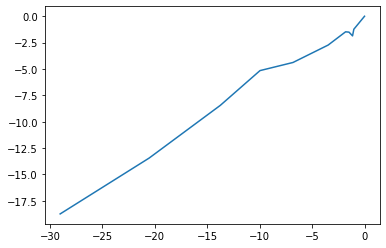

In [62]:
X=pos
######################################################
# Paramters
######################################################
u_t = np.array([0, 0]) # we assume constant control input
a=X[0:4]; A=a.reshape([2,2])
B = np.array([[1, 0],
            [0, 1]])
q=X[4:8]; Q=q.reshape([2,2])
h=X[8:12]; H=h.reshape([2,2])
r=X[12:]; R=r.reshape([2,2])
######################################################
motion_states = motion_states = [np.array([0, 0])]  # a list to store state at each step following noisy motion model
# motion_states = [filtered_states[filtered_states.shape[0]-1,:]] # a list to store state at each step following noisy motion model
for _ in range(10):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q) # ~N(0,Q)
    new_state = A @ motion_states[-1] + B @ u_t + motion_noise # note: a @ b = np.dot(a,b)
    motion_states.append(new_state)

motion_states = np.array(motion_states)
plt.plot(motion_states[:,0], motion_states[:,1])

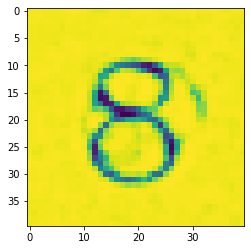

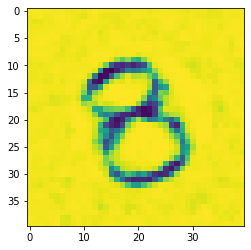

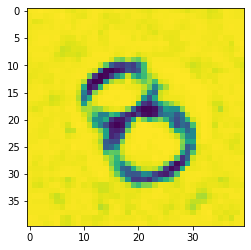

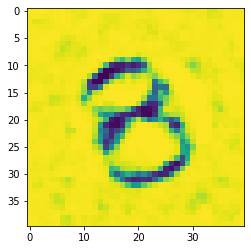

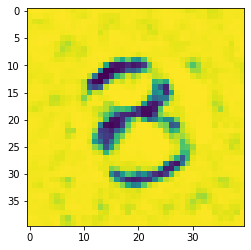

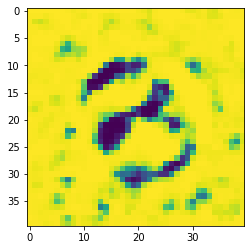

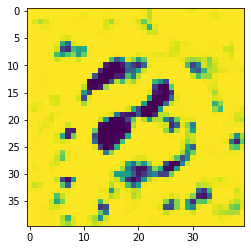

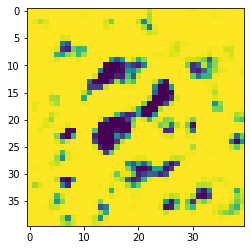

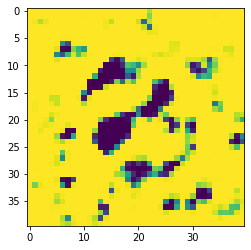

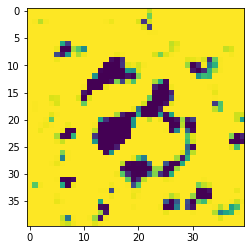

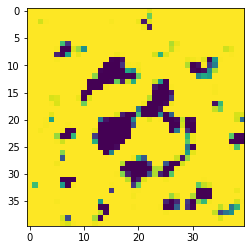

In [63]:
######################################################
#plot of the prediction the 
######################################################
Z_SAMPLE=motion_states
row=Z_SAMPLE.shape[0]
# z_sample=np.zeros((1,2))
for k in range(row):
  z_sample = Z_SAMPLE[k].reshape(1,2)
  x_decoded = vae.decoder.predict(z_sample)
  #print(x_decoded[0].shape)
  digit = x_decoded[0].reshape(image_size, image_size)
  # plt.imshow(digit)
  # axs[i].set_title('recustructed image for time:'+ str(t)+'based on bias:'+str(Bias[i]))
  # #fig.suptitle('f model'+ str(i))
  plt.show()
  plt.imshow(digit)


### **Kalman Filter with Neural Network for Paramter**